In [68]:
import cv2
import numpy as np
import math
from collections import defaultdict
import csv
import matplotlib.pyplot as plt

import ft_lib

In [69]:

class BubbleTracker:
    def __init__(self, max_distance=50):
        self.next_id = 0
        self.bubbles = {}  # id -> (cx, cy)
        self.history = defaultdict(list)  # id -> list of (frame, cx, cy, area)
        self.max_distance = max_distance

    def update(self, detections, frame_num):
        updated_ids = set()
        new_bubbles = {}

        for (cx, cy, area) in detections:
            matched_id = None
            min_dist = self.max_distance

            for bubble_id, (prev_cx, prev_cy) in self.bubbles.items():
                dist = math.hypot(cx - prev_cx, cy - prev_cy)
                if dist < min_dist:
                    matched_id = bubble_id
                    min_dist = dist

            if matched_id is not None:
                # Existing bubble
                new_bubbles[matched_id] = (cx, cy)
                self.history[matched_id].append((frame_num, cx, cy, area))
                updated_ids.add(matched_id)
            else:
                # New bubble
                bubble_id = self.next_id
                self.next_id += 1
                new_bubbles[bubble_id] = (cx, cy)
                self.history[bubble_id].append((frame_num, cx, cy, area))
                updated_ids.add(bubble_id)

        self.bubbles = {k: v for k, v in new_bubbles.items() if k in updated_ids}

    def get_tracks(self):
        return self.history


In [70]:

video_path = "input_files/1mm_synced.mp4"
output_path = "video_out/output.mp4"
cap = cv2.VideoCapture(video_path)
fps = 240

crop_x = (300,720)
crop_y = (300, 1100)
width = crop_x[1] - crop_x[0]
height = crop_y[1] - crop_y[0]

fps = cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

if not cap.isOpened():
    print("Error opening video file")
    exit()


frame_num = 0
tracker = BubbleTracker(max_distance=100)


while True:
    
    frame_num += 1
    
    print(f"time: {frame_num/fps:.2f}s")
    ret, frame = cap.read()
    if not ret:
        break  # End of video

    # Crop the frame
    cropped_frame = frame[crop_y[0]:crop_y[1], crop_x[0]:crop_x[1]]

    # grayscale
    gray_frame = cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2GRAY)

    blurred_frame = cv2.GaussianBlur(gray_frame, (11,11), 0)

    # Apply Canny edge detection
    edges = cv2.Canny(blurred_frame, 10, 15)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    edges = cv2.dilate(edges, kernel, iterations=1)

    # cv2.imwrite(f"edges//edge{frame_num}.jpg", edges)


    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    detected_bubbles = []
    
    # Initialize the bubble tracker
    for contour in contours:
        area = cv2.contourArea(contour)
        if area < 1500:
          continue

        #approx polygon
        epsilon = 0.005 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        #draw the polygon
        cv2.polylines(cropped_frame, [approx], isClosed=True, color=(0, 255, 0), thickness=2)

        # Compute center of the polygon to place text
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
        else:
            cx, cy = approx[0][0]  # fallback to first vertex

        # Collect detection
        detected_bubbles.append((cx, cy, area))
        
        # Draw area text
        cv2.putText(cropped_frame, f"{int(area)}", (cx, cy),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
        
    
    tracker.update(detected_bubbles, frame_num)
    for bubble_id, history in tracker.get_tracks().items():
        if history and history[-1][0] == frame_num:
            _, cx, cy, area = history[-1]
            cv2.putText(cropped_frame, f"ID:{bubble_id}", (cx + 25, cy + 25), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1)
        
    out.write(cropped_frame)

    # Exit on ESC key
    if cv2.waitKey(25) & 0xFF == 27:
        break
    
    

cap.release()
out.release()
cv2.destroyAllWindows()


time: 0.05s
time: 0.10s
time: 0.15s
time: 0.20s
time: 0.25s
time: 0.30s
time: 0.35s
time: 0.40s
time: 0.45s
time: 0.50s
time: 0.55s
time: 0.60s
time: 0.65s
time: 0.70s
time: 0.75s
time: 0.80s
time: 0.85s
time: 0.90s
time: 0.95s
time: 1.00s
time: 1.05s
time: 1.10s
time: 1.15s
time: 1.20s
time: 1.25s
time: 1.30s
time: 1.35s
time: 1.40s
time: 1.45s
time: 1.50s
time: 1.55s
time: 1.60s
time: 1.65s
time: 1.70s
time: 1.75s
time: 1.80s
time: 1.85s
time: 1.90s
time: 1.95s
time: 2.00s
time: 2.05s
time: 2.10s
time: 2.15s
time: 2.20s
time: 2.25s
time: 2.30s
time: 2.35s
time: 2.40s
time: 2.45s
time: 2.50s
time: 2.55s
time: 2.60s
time: 2.65s
time: 2.70s
time: 2.75s
time: 2.80s
time: 2.85s
time: 2.90s
time: 2.95s
time: 3.00s
time: 3.05s
time: 3.10s
time: 3.15s
time: 3.20s
time: 3.25s
time: 3.30s
time: 3.35s
time: 3.40s
time: 3.45s
time: 3.50s
time: 3.54s
time: 3.59s
time: 3.64s
time: 3.69s
time: 3.74s
time: 3.79s
time: 3.84s
time: 3.89s
time: 3.94s
time: 3.99s
time: 4.04s
time: 4.09s
time: 4.14s
time

KeyboardInterrupt: 

In [ ]:
with open("bubble_tracks.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["BubbleID", "Frame", "X", "Y", "Area"])
    for bubble_id, track in tracker.get_tracks().items():
        for (frame, x, y, area) in track:
            writer.writerow([bubble_id, frame, x, y, area])

Generate the time/graphs

In [ ]:
# Create a dictionary to store (time, area) for each bubble ID
result_dict = {}

for bubble_id, track in tracker.get_tracks().items():
    if len(track) > 30:
        times = []
        areas = []
        for (frame, x, y, area) in track:
            times.append(frame / fps)  # Convert frame number to seconds
            areas.append(area)
        result_dict[bubble_id] = (times, areas)

result_dict  # This will contain { bubble_id: ([time...], [area...]) }


{3: ([0.04992870293831857,
   0.09985740587663713,
   0.1497861088149557,
   0.19971481175327427,
   0.19971481175327427,
   0.24964351469159282,
   0.24964351469159282,
   0.2995722176299114,
   0.34950092056822996,
   0.39942962350654854,
   0.44935832644486706,
   0.49928702938318564,
   0.5492157323215042,
   0.5991444352598227,
   0.6490731381981414,
   0.6990018411364599,
   0.7489305440747784,
   0.7988592470130971,
   0.7988592470130971,
   0.8487879499514156,
   0.8487879499514156,
   0.8987166528897341,
   0.8987166528897341,
   0.9486453558280528,
   0.9985740587663713,
   0.9985740587663713,
   0.9985740587663713,
   1.0485027617046898,
   1.0485027617046898,
   1.0984314646430084,
   1.148360167581327,
   1.1982888705196455,
   1.2482175734579641,
   1.2981462763962828,
   1.3480749793346012,
   1.3980036822729198,
   1.4479323852112385],
  [11861.5,
   12228.5,
   10966.5,
   3387.0,
   7868.5,
   3580.0,
   7102.0,
   7138.5,
   7763.0,
   7374.0,
   6988.5,
   7001.5,
 

c:\Users\eitan\OneDrive - huji.ac.il\EitanDina\BubbleAlgorithm\ft_lib.py


C:\Users\eitan\AppData\Local\Temp\ipykernel_17248\1701346090.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharex=False)
C:\Users\eitan\AppData\Local\Temp\ipykernel_17248\1701346090.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))


ValueError: Invalid number of FFT data points (0) specified.

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

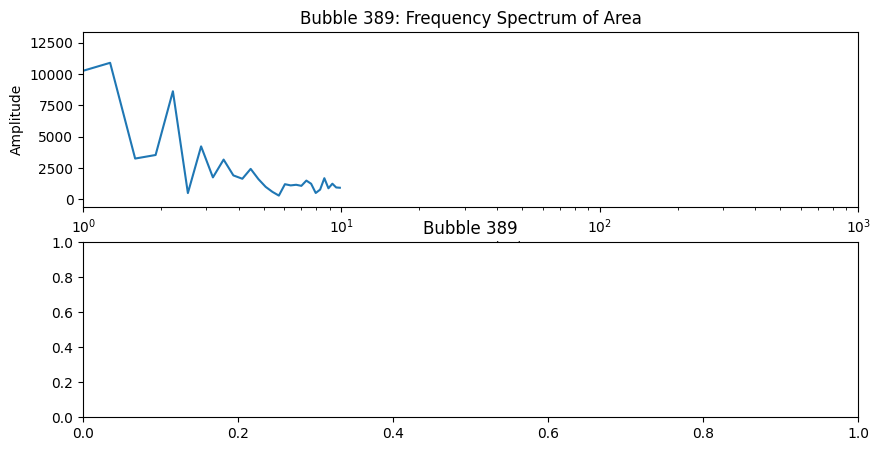

In [73]:
import os
import ft_lib
print(ft_lib.__file__)
out_dir = "plot_out"


# Delete all files in plot_out directory
if os.path.exists(out_dir):
    for filename in os.listdir(out_dir):
        file_path = os.path.join(out_dir, filename)
        if os.path.isfile(file_path):
            os.remove(file_path)
else:
    os.makedirs(out_dir)
    
    
for bubble in result_dict:
    plt.figure(figsize=(10, 5))
    
    times, areas = result_dict[bubble]
    # Compute FFT of area signal
    area_arr = np.array(areas)
    n = len(area_arr)
    dt = np.mean(np.diff(times))  # average time step
    freqs = np.fft.rfftfreq(n, d=dt)
    fft_vals = np.fft.rfft(area_arr - np.mean(area_arr))

    time_interval = (times[0], times[-1])
    fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharex=False)
    plt.title(f"Bubble {bubble}")
    
    axs[0].plot(freqs, np.abs(fft_vals))
    axs[0].set_xlabel("Frequency (Hz)")
    axs[0].set_ylabel("Amplitude")
    axs[0].set_xlim(1, 1000)
    axs[0].set_xscale("log")
    axs[0].set_title(f"Bubble {bubble}: Frequency Spectrum of Area")
    
    freq, ampl = ft_lib.get_freq_from_wav_file("sound_in/cut-1mm.wav", times[0], times[-1])
    
    axs[1].plot(freq, ampl)
    axs[1].set_xlabel("Frequency (Hz)")
    axs[1].set_ylabel("Amplitude")
    axs[1].set_title(f"Bubble {bubble}: Frequency Spectrum of Sound")
    axs[1].set_xlim(1, 1000)
    axs[1].set_xscale("log")
    
    
    plt.savefig(os.path.join(out_dir, f"bubble_{bubble}_fft.png"))
    plt.close()
    

    
    
    
    
    